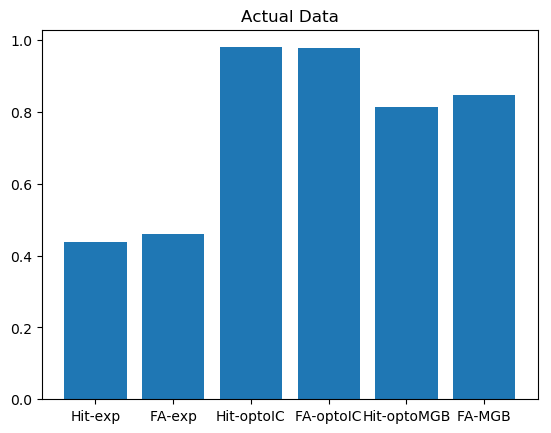

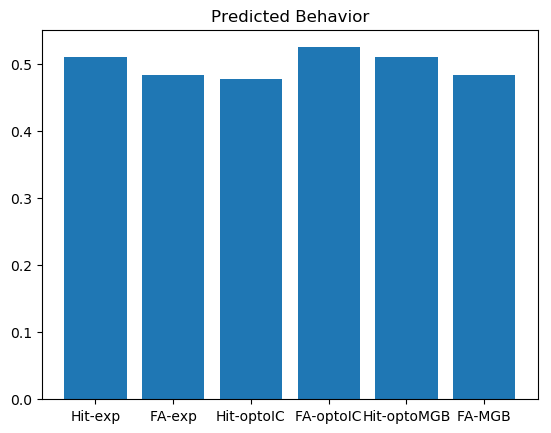

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def four_param_model(x):
    ICvar = x[0]
    MGBgain = x[1]
    cri = x[2]
    cri_opto = x[3]

    IC = build_distribution(2, ICvar, -2, ICvar)
    MGB = build_distribution(2, ICvar / MGBgain, -2, ICvar / MGBgain)

    expert = apply_criteria(MGB, cri)
    opto_IC = apply_criteria(IC, cri_opto)
    opto_MGB = apply_criteria(MGB, cri_opto)

    out = [expert['hit'], expert['fa'], opto_IC['hit'], opto_IC['fa'], opto_MGB['hit'], opto_MGB['fa']]
    return np.array(out)

def my_error(x, y):
    return np.sum((y - four_param_model(x)) ** 2)

def build_distribution(arg1, var1, arg2, var2):
    # Placeholder for your actual implementation of build_distribution
    return {'target': np.random.normal(arg2, var1, 1000), 'foil': np.random.normal(arg2, var2, 1000)}

def apply_criteria(dist, criterion):
    # Placeholder for your actual implementation of apply_criteria
    hit = np.mean(dist['target'] > criterion)
    fa = np.mean(dist['foil'] > criterion)
    return {'hit': hit, 'fa': fa}

out = four_param_model([5, 0.5, 1, -10]) # actual data
plt.figure()
plt.bar(range(1, 7), out)
plt.title('Actual Data')
plt.xticks(np.arange(1, 7), ['Hit-exp', 'FA-exp', 'Hit-optoIC', 'FA-optoIC', 'Hit-optoMGB', 'FA-MGB'])
plt.show()

y = np.array([0.9, 0.1, 0.9, 0.9, 0.6, 0.4])
initial_guess = [1, 0, 1, 0]
# Minimize the error function
result = minimize(my_error, initial_guess, args=(y,), bounds=[(1e-6, 100), (1e-6, 100), (-100, 100), (-100, 100)])
pred_behav = four_param_model(result.x)
plt.figure()
plt.bar(range(1, 7), pred_behav)
plt.title('Predicted Behavior')
plt.xticks(np.arange(1, 7), ['Hit-exp', 'FA-exp', 'Hit-optoIC', 'FA-optoIC', 'Hit-optoMGB', 'FA-MGB'])
plt.show()